In [1]:
import sys
sys.path.append(r'D:\github\ripple_heterogeneity\python')
import functions,loading,replay_run

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import importlib
import glob
import os
import pickle
import replay_fig
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
import random

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [227]:
# def get_replay_epochs(results,direction,alpha=0.05):

#     if not np.any((direction == 'forward') | (direction == 'reverse')):
#         print('wrong direction')
#         return 
#     starts = [] 
#     stops = []

#     idx = (results[direction]['df'].score_pval_time_swap <= alpha) & (results[direction]['df'].replay_type == direction)
#     starts.append(results[direction]['df'][idx].start)
#     stops.append(results[direction]['df'][idx].stop)

#     idx = (results['inbound_epochs']['df'].score_pval_time_swap <= alpha) & (results['inbound_epochs']['df'].replay_type == direction)
#     starts.append(results['inbound_epochs']['df'][idx].start)
#     stops.append(results['inbound_epochs']['df'][idx].stop)

#     sort_idx = np.argsort(np.hstack(starts))

#     starts = np.hstack(starts)[sort_idx]
#     stops = np.hstack(stops)[sort_idx]

#     return nel.EpochArray(np.array([starts,stops]).T)

def get_replay_epochs(results,replay_type,direction,alpha=0.05):

    if not np.any((replay_type == 'forward') | (replay_type == 'reverse')):
        raise Exception('wrong replay_type')

    if not np.any((direction == 'outbound_epochs') | (direction == 'inbound_epochs')):
        raise Exception('wrong direction')

    idx = (results[direction]['df'].score_pval_time_swap <= alpha) & (results[direction]['df'].replay_type == replay_type)
    starts = results[direction]['df'][idx].start.values
    stops = results[direction]['df'][idx].stop.values

    sort_idx = np.argsort(starts)

    starts = starts[sort_idx]
    stops = stops[sort_idx]

    return nel.EpochArray(np.array([starts,stops]).T)

In [301]:
import warnings
warnings.filterwarnings("ignore", message="All-NaN slice encountered")

importlib.reload(functions)

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay'
sessions = glob.glob(save_path +os.sep+ '*.pkl')

df_rank_order = pd.DataFrame()
for session in sessions:
    with open(session, 'rb') as f:
        results = pickle.load(f)

        try:
            basepath = results['outbound_epochs']['df'].basepath.unique()[0]
        except:
            basepath = results['inbound_epochs']['df'].basepath.unique()[0]

        st,cell_metrics = loading.load_spikes(basepath,putativeCellType='Pyr')

        epochs = {
                'forward_outbound_replay': get_replay_epochs(results,'forward','outbound_epochs'),
                'forward_inbound_replay': get_replay_epochs(results,'forward','inbound_epochs'),
                'reverse_outbound_replay': get_replay_epochs(results,'reverse','outbound_epochs'),
                'reverse_inbound_replay': get_replay_epochs(results,'reverse','inbound_epochs')
                }

        # make pre/task/post
        epoch_df = loading.load_epoch(basepath)
        pattern_idx,_ = functions.find_epoch_pattern(epoch_df.environment,['sleep','linear','sleep'])
        epoch_df = epoch_df[pattern_idx]
        behavior_epochs = nel.EpochArray([np.array([epoch_df.startTime,
                                                    epoch_df.stopTime]).T])

        median_rank_order = []
        label = []
        deepSuperficial = []
        environment = []
        for beh_i,beh_epoch in enumerate(behavior_epochs):
            for key_ in  epochs.keys():
                temp_rank_order,rank_order = functions.get_rank_order(st[beh_epoch],epochs[key_])
                median_rank_order.append(temp_rank_order)
                label.append([key_]*len(temp_rank_order))
                deepSuperficial.append(cell_metrics.deepSuperficial)
                environment.append([beh_i]*len(temp_rank_order))

        df_rank_order_temp = pd.DataFrame()
        df_rank_order_temp['median_rank_order'] = np.hstack(median_rank_order)
        df_rank_order_temp['label'] = np.hstack(label)
        df_rank_order_temp['basepath'] = basepath
        df_rank_order_temp['deepSuperficial'] = np.hstack(deepSuperficial)
        df_rank_order_temp['environment'] = np.hstack(environment)

    df_rank_order = pd.concat([df_rank_order,df_rank_order_temp])

Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 563, in _pydevd_bundle.pydevd_cython.PyDBFrame._handle_exception
  File "_pydevd_bundle/pydevd_cython.pyx", line 297, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 1976, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 2011, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


ValueError: too many values to unpack (expected 2)

In [285]:
df_rank_order

,median_rank_order,label,basepath,deepSuperficial,environment
0,0.625000,forward_outbound_replay,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,Deep,0
1,0.444444,forward_outbound_replay,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,Superficial,0
2,0.531250,forward_outbound_replay,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,Deep,0
3,0.406250,forward_outbound_replay,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,Deep,0
4,0.083333,forward_outbound_replay,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,Deep,0
...,...,...,...,...,...
2887,0.530000,reverse_inbound_replay,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,Superficial,2
2888,0.376471,reverse_inbound_replay,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,Deep,2
2889,NaN,reverse_inbound_replay,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,Deep,2
2890,0.202500,reverse_inbound_replay,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,Deep,2


In [288]:
[df_rank_order['label'] + df_rank_order['deepSuperficial']]

[0              forward_outbound_replayDeep
 1       forward_outbound_replaySuperficial
 2              forward_outbound_replayDeep
 3              forward_outbound_replayDeep
 4              forward_outbound_replayDeep
                        ...                
 2887     reverse_inbound_replaySuperficial
 2888            reverse_inbound_replayDeep
 2889            reverse_inbound_replayDeep
 2890            reverse_inbound_replayDeep
 2891            reverse_inbound_replayDeep
 Length: 2892, dtype: object]

In [289]:
df_rank_order['label_lay'] = df_rank_order['label'] + df_rank_order['deepSuperficial']

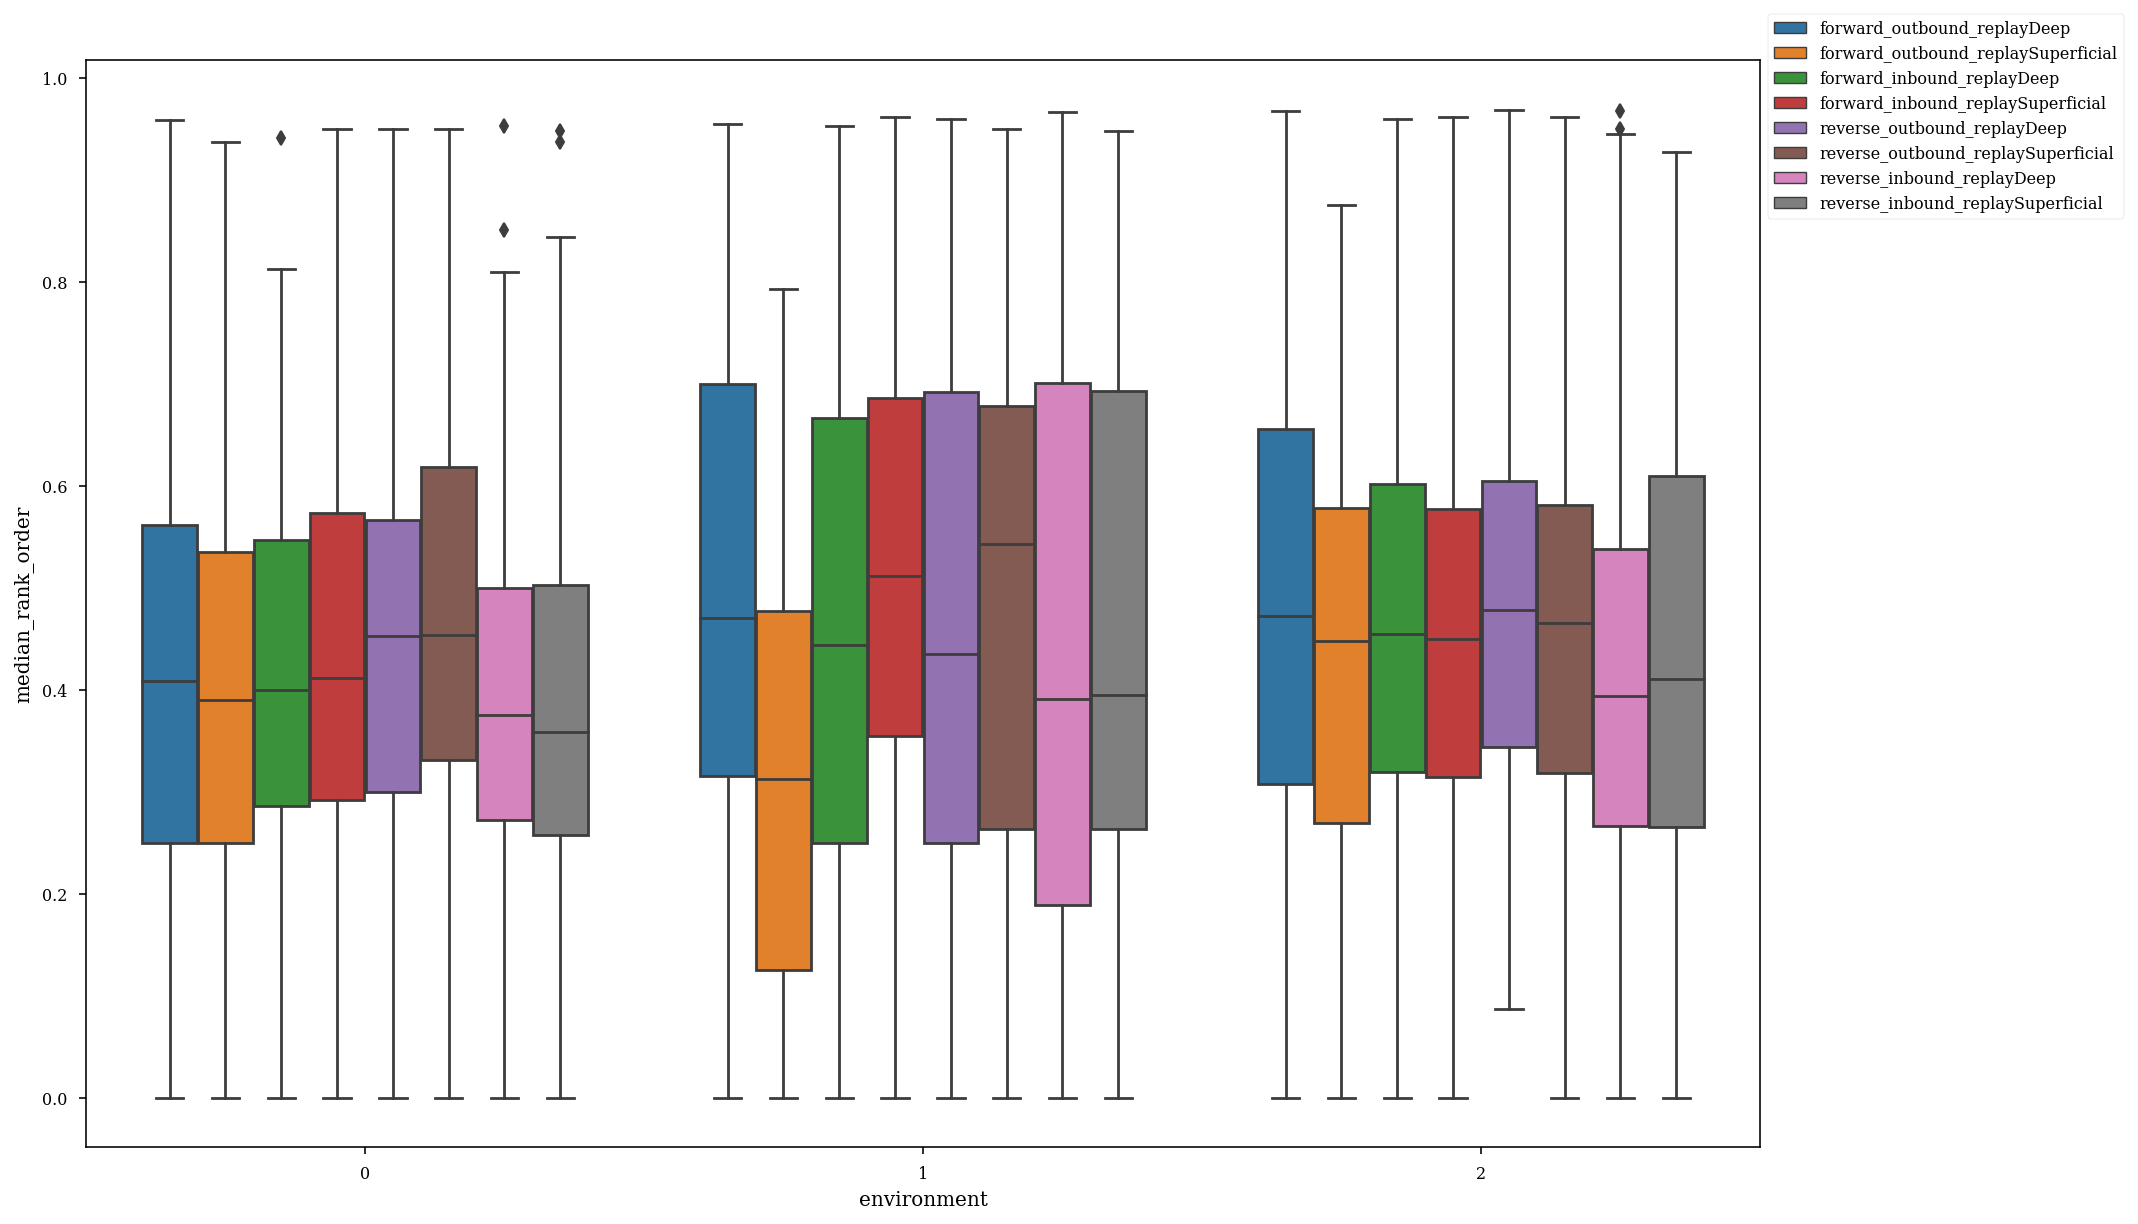

In [297]:

plt.figure(figsize=(15,10))
sns.boxplot(x="environment", y="median_rank_order",
            hue="label_lay",
            data=df_rank_order)

plt.legend(bbox_to_anchor=(1, 1.05))


In [249]:
importlib.reload(functions)

median_rank_order = []
label = []
for key_ in  epochs.keys():
    temp_rank_order,rank_order = functions.get_rank_order(st,epochs[key_])
    median_rank_order.append(temp_rank_order)
    label.append([key_]*len(temp_rank_order))

df_rank_order = pd.DataFrame()
df_rank_order['median_rank_order'] = np.hstack(median_rank_order)
df_rank_order['label'] = np.hstack(label)

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered


## testing below

In [252]:
df_rank_order['label'].unique()

array(['forward_outbound_replay', 'forward_inbound_replay',
       'reverse_outbound_replay', 'reverse_inbound_replay'], dtype=object)

Text(0, 0.5, 'rank order')

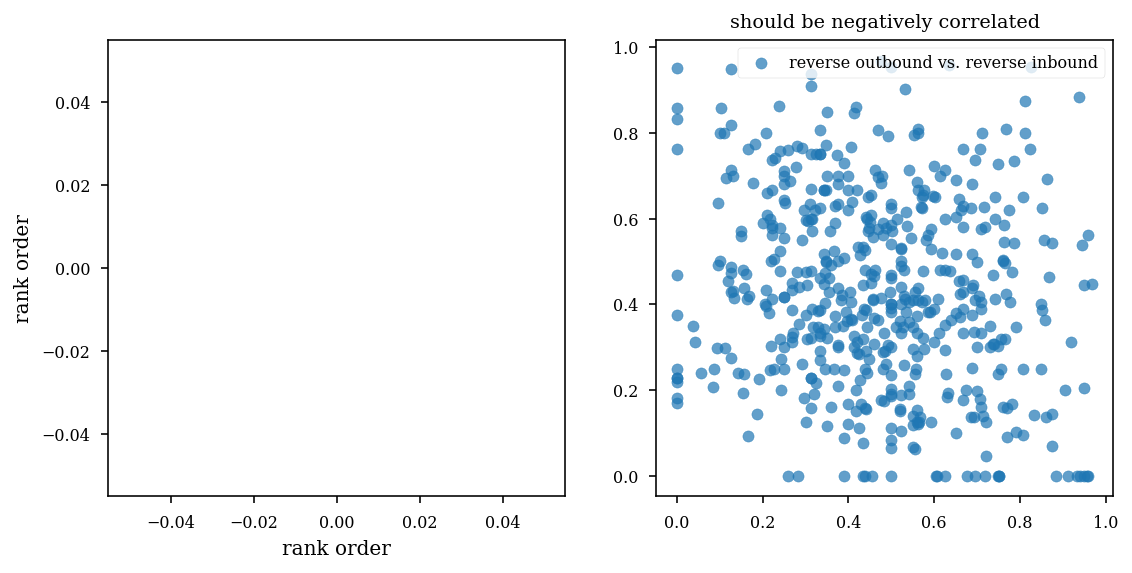

In [278]:
df_rank_order = pd.DataFrame()
df_rank_order['median_rank_order'] = np.hstack(median_rank_order)
df_rank_order['label'] = np.hstack(label)

fig,ax = plt.subplots(1,2,figsize=(9,9))

# ax[0].scatter(df_rank_order[df_rank_order.label == 'forward_outbound_replay'].median_rank_order,
#             df_rank_order[df_rank_order.label == 'reverse_inbound_replay'].median_rank_order,alpha=.7,
#             label='forward outbound vs. reverse inbound')

# ax[0].scatter(df_rank_order[df_rank_order.label == 'forward_inbound_replay'].median_rank_order,
#             df_rank_order[df_rank_order.label == 'reverse_outbound_replay'].median_rank_order,alpha=.7,
#             label='forward inbound vs. reverse outbound')
# ax[0].legend()
# ax[0].set_title('should be positively correlated')

# ax[1].scatter(df_rank_order[df_rank_order.label == 'forward_outbound_replay'].median_rank_order,
#             df_rank_order[df_rank_order.label == 'forward_inbound_replay'].median_rank_order,alpha=.7,
#             label='forward outbound vs. forward inbound')

ax[1].scatter(df_rank_order[df_rank_order.label == 'reverse_outbound_replay'].median_rank_order,
            df_rank_order[df_rank_order.label == 'forward_outbound_replay'].median_rank_order,alpha=.7,
            label='reverse outbound vs. reverse inbound')
ax[1].set_title('should be negatively correlated')
ax[1].legend()

ax[0].axis('square')
ax[1].axis('square')

ax[0].set_xlabel('rank order')
ax[0].set_ylabel('rank order')


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\matplotlib\axes\_axes.py:6731: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\matplotlib\axes\_axes.py:6732: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\matplotlib\axes\_axes.py:6731: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\matplotlib\axes\_axes.py:6732: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\matplotlib\axes\_axes.py:6731: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\matplotlib\axes\_axes.py:6732: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\matplotlib\axes\_axes.py:6731: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\ana

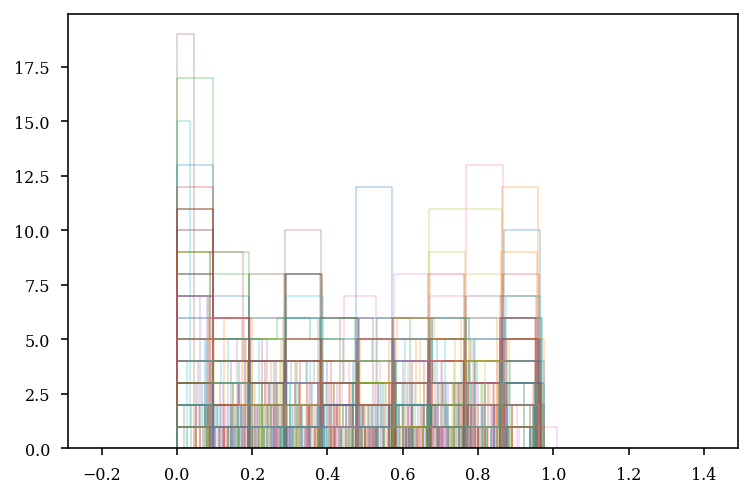

In [218]:
for i in range(rank_order.shape[0]):
    try:
        plt.hist(rank_order[i,:],histtype='step')
    except:
        pass
# plt.hist(rank_order[0,:],histtype='step')

plt.show()

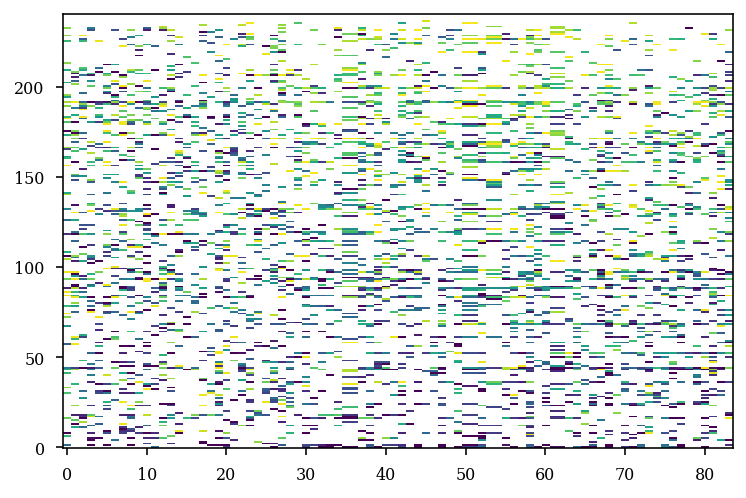

In [219]:
# plt.plot(np.sort(mean_rank))
plt.imshow(rank_order[np.argsort(mean_rank),:],aspect='auto',interpolation='nearest',origin='lower')

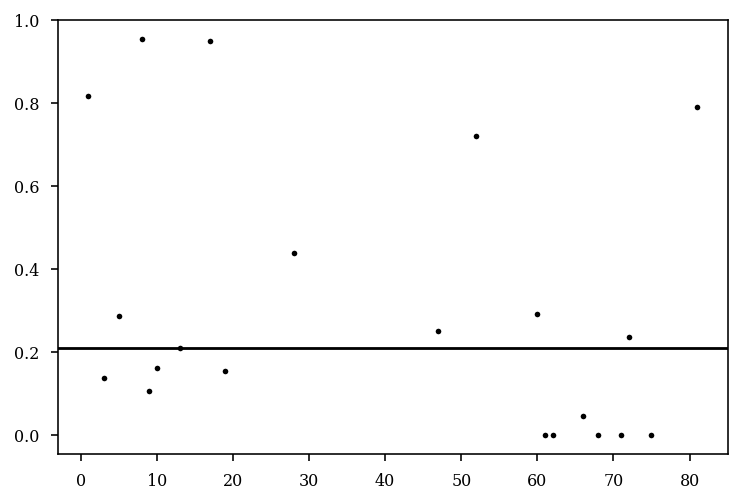

In [222]:
cell = 20
plt.plot(rank_order[cell,:],'.k')
plt.axhline(mean_rank[cell],color='k')

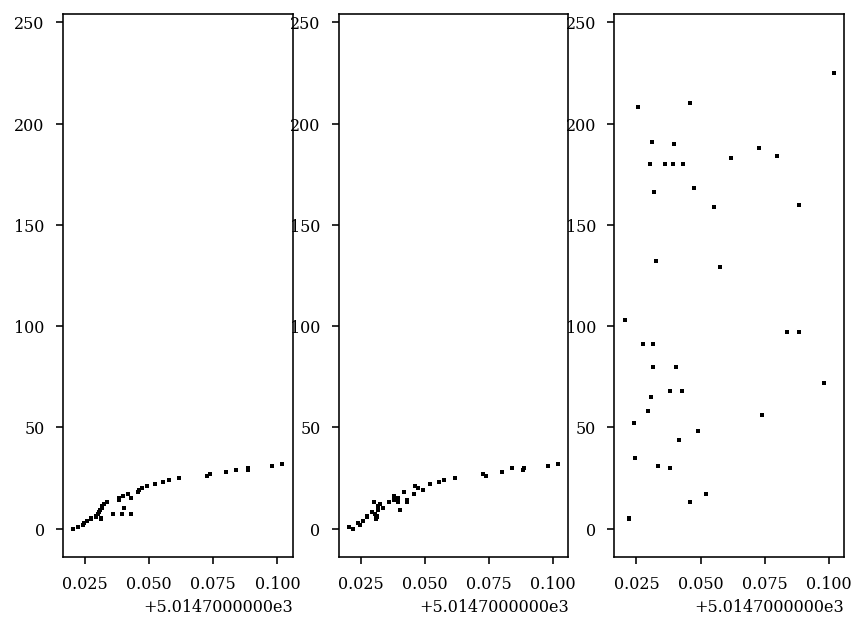

In [221]:
rip = 4

fig,ax = plt.subplots(1,3,figsize=(7,5))

order_idx = np.array(st[forward_replay[rip]].get_event_firing_order())-1
ax[0].eventplot(st[forward_replay[rip]].data[order_idx],linewidths=2,linelengths=2,color='k')

ax[1].eventplot(st[forward_replay[rip]].data[np.argsort(rank_order[:,rip])],linewidths=2,linelengths=2,color='k')

ax[2].eventplot(st[forward_replay[rip]].data[np.argsort(mean_rank)],linewidths=2,linelengths=2,color='k')

# ax[0].set_ylim(0,50)
# ax[1].set_ylim(0,50)

plt.show()

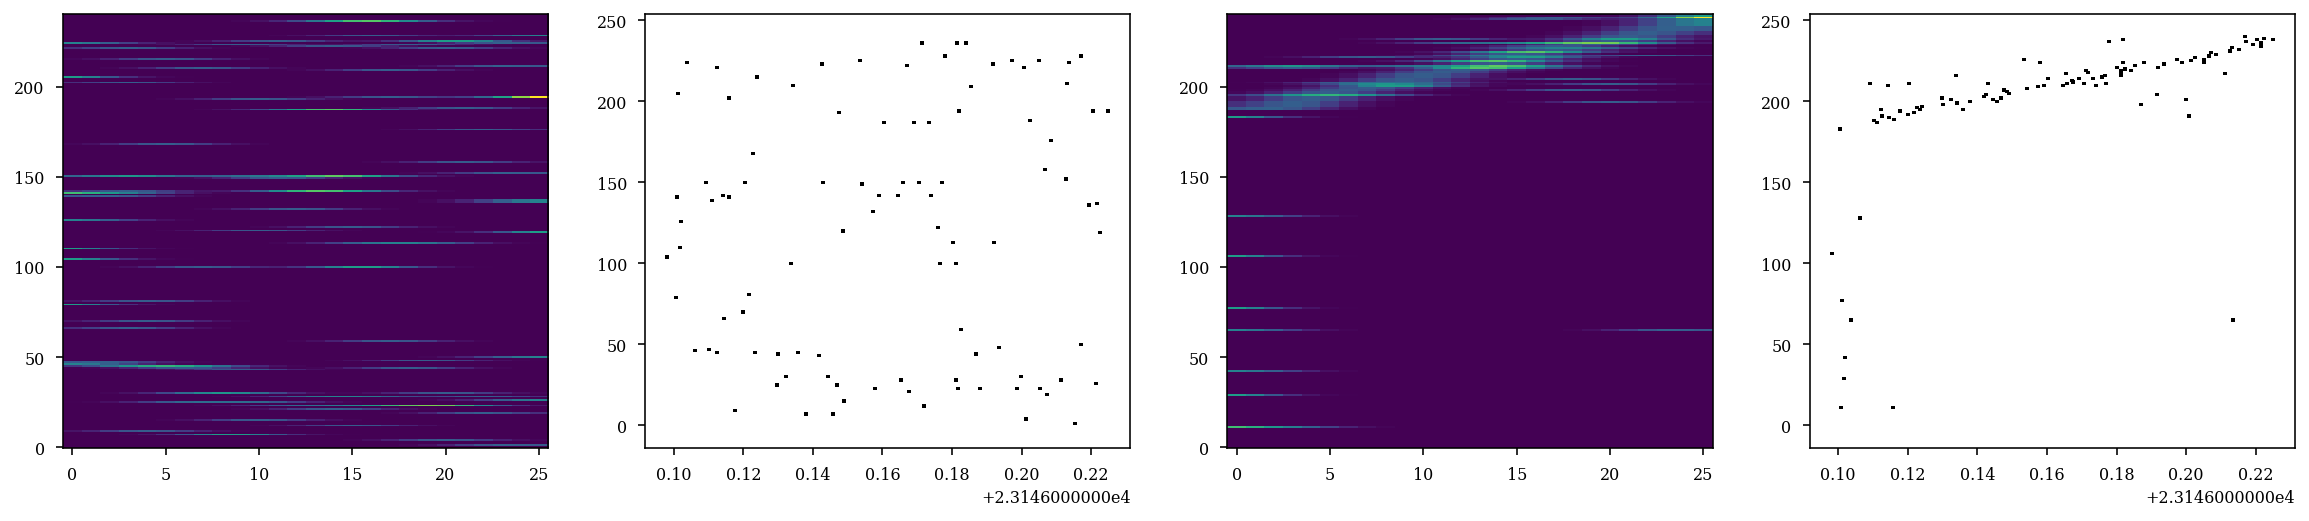

In [103]:
rip = 50
z_t = st[forward_replay[rip]].bin(ds=.005)
z_t.smooth(sigma=0.01,inplace=True)

fig,ax = plt.subplots(1,4,figsize=(20,4))
ax[0].imshow(z_t.data,aspect='auto',interpolation='nearest',origin='lower')
ax[1].eventplot(st[forward_replay[rip]].data,linewidths=2,linelengths=2,color='k')

peak_idx = []
for unit in z_t.data:
    peak_idx.append(np.argmax(unit))
reorder_idx = np.argsort(peak_idx)

ax[2].imshow(z_t.data[reorder_idx,:],aspect='auto',interpolation='nearest',origin='lower')

ax[3].eventplot(st[forward_replay[rip]].data[reorder_idx],linewidths=2,linelengths=2,color='k')
plt.show()

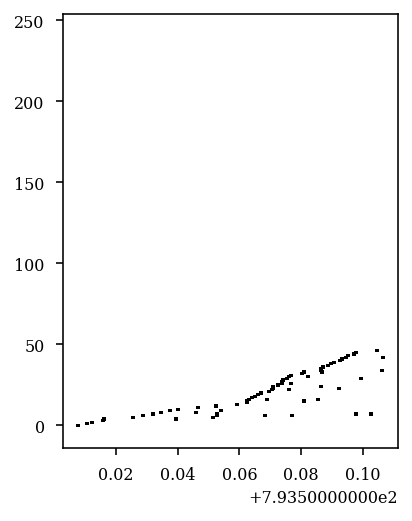

In [52]:
rip = 0
order_idx = np.array(st[forward_replay[rip]].get_event_firing_order())-1

plt.figure(figsize=(3,4))
plt.eventplot(st[forward_replay[rip]].data[order_idx],linewidths=2,linelengths=2,color='k')
plt.show()

# plt.figure()
# ax = plt.gca()
# raster_lw=2
# raster_lh=2
# npl.rasterplot(st[forward_replay[0]], vertstack=True, ax=ax, lh=raster_lh,lw=raster_lw)


In [27]:
results.keys()

dict_keys(['outbound_epochs', 'inbound_epochs'])

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


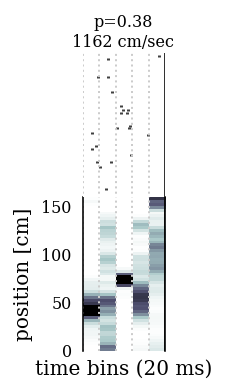

In [33]:
# importlib.reload(replay_fig)
import replay_fig
idxs = np.where((results['outbound_epochs']['df']['score_pval_col_cycle']<0.05))[0]
idx = idxs[0]
idx = int(idx)
if isinstance(idx, int):
    title = "p={:.2f}\n{:.0f} cm/sec".format(results['outbound_epochs']['df'].trajectory_score.iloc[idx],
                                             results['outbound_epochs']['df'].traj_speed.iloc[idx])
else:
    title = ""
ax = replay_fig.plot_all_replay(results['outbound_epochs']['bst_placecells'][idx],
                                        results['outbound_epochs']['sta_placecells'],
                                        results['outbound_epochs']['tc'],
                                        results['outbound_epochs']['tc'],
                                        vmax=.1,
                                        title_str=title) 